<a href="https://colab.research.google.com/github/skywalker0803r/c620/blob/main/notebook/Integration_and_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import joblib
import os
import numpy as np
import pandas as pd
#!pip install autorch
import matplotlib.pyplot as plt
import autorch
from autorch.function import sp2wt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Predict Class

In [3]:
class Predict(object):
  def __init__(self):
    # sf
    self.model_c620_sf = joblib.load('/content/drive/MyDrive/台塑輕油案子/data/c620/model/c620.pkl')
    self.model_c660_sf = joblib.load('/content/drive/MyDrive/台塑輕油案子/data/c620/model/c660.pkl')
    self.model_c670_sf = joblib.load('/content/drive/MyDrive/台塑輕油案子/data/c620/model/c670.pkl')

    # op
    self.model_c620_op = joblib.load('/content/drive/MyDrive/台塑輕油案子/data/c620/model/c620.pkl')
    self.model_c660_op = joblib.load('/content/drive/MyDrive/台塑輕油案子/data/c620/model/c660.pkl')
    self.model_c670_op = joblib.load('/content/drive/MyDrive/台塑輕油案子/data/c620/model/c670.pkl')
      
    #c620
    self.c620_col_names = joblib.load('/content/drive/MyDrive/台塑輕油案子/data/c620/col_names/c620_col_names.pkl') 
    self.c620_df = pd.read_csv('/content/drive/MyDrive/台塑輕油案子/data/c620/cleaned/c620_train.csv',index_col=0)
    self.c620_mb = pd.read_csv('/content/drive/MyDrive/台塑輕油案子/data/c620/cleaned/c620_mbcheck.csv',index_col=0)
    
    #t651
    self.t651_col_names = joblib.load('/content/drive/MyDrive/台塑輕油案子/data/c620/col_names/t651_col_names.pkl')
    self.t651_df = pd.read_csv('/content/drive/MyDrive/台塑輕油案子/data/c620/cleaned/t651_train.csv',index_col=0)
    
    #c660
    self.c660_col_names = joblib.load('/content/drive/MyDrive/台塑輕油案子/data/c620/col_names/c660_col_names.pkl')
    self.c660_df = pd.read_csv('/content/drive/MyDrive/台塑輕油案子/data/c620/cleaned/c660_train.csv',index_col=0)
    
    #c670
    self.c670_col_names = joblib.load('/content/drive/MyDrive/台塑輕油案子/data/c620/col_names/c670_col_names.pkl')
    self.c670_df = pd.read_csv('/content/drive/MyDrive/台塑輕油案子/data/c620/cleaned/c670_train.csv',index_col=0)
    self.c670_mb = pd.read_csv('/content/drive/MyDrive/台塑輕油案子/data/c620/cleaned/c670_mbcheck.csv',index_col=0)
    
  # Load c620 input
  def load_c620(self):
    c620_x = self.c620_df[self.model_c620_sf.x_col]
    return c620_x
    
  # Predict c620 WT
  def c620_wt(self,c620_x):
    idx = c620_x.index
    c620_sf = self.model_c620_sf.predict(c620_x).iloc[:,:41*4]
    x41 = c620_x[self.c620_col_names['x41']].values
    s1 = c620_sf[self.c620_col_names['vent_gas_sf']].values
    s2 = c620_sf[self.c620_col_names['distillate_sf']].values
    s3 = c620_sf[self.c620_col_names['sidedraw_sf']].values
    s4 = c620_sf[self.c620_col_names['bottoms_sf']].values
    w1 = sp2wt(x41,s1)
    w2 = sp2wt(x41,s2)
    w3 = sp2wt(x41,s3)
    w4 = sp2wt(x41,s4)
    c620_wt = np.hstack((w1,w2,w3,w4))
    c620_wt = pd.DataFrame(
        c620_wt,
        index = idx,
        columns = 
        self.c620_col_names['vent_gas_x']+\
        self.c620_col_names['distillate_x']+\
        self.c620_col_names['sidedraw_x']+\
        self.c620_col_names['bottoms_x'])
    return c620_wt

  # Predict c620 OP
  def c620_op(self,c620_x):
    c620_op = self.model_c620_op.predict(c620_x)
    return c620_op.iloc[:,41*4:] 
    
  # Load c660 input
  def load_c660(self,c620_w3):
    idx = c620_w3.index
    feed_t651 = self.t651_df.loc[idx,self.t651_col_names['x41']]
    
    t651_mf = self.t651_df.loc[idx,self.t651_col_names['MFR']]
    c620_mf = self.c620_mb.loc[idx].iloc[:,[3]]
    
    total = t651_mf.values + c620_mf.values
    t651_mf = t651_mf/total
    c620_mf = c620_mf/total

    c660_feed = c620_w3.values*c620_mf.values + feed_t651.values*t651_mf.values
    c660_feed = pd.DataFrame(c660_feed,index=idx,columns=self.c660_col_names['x41'])
    c660_case = self.c660_df.loc[idx,self.c660_col_names['case']]
    return c660_case.join(c660_feed)
    
  #Predict c660 WT
  def c660_wt(self,c660_x):
    idx = c660_x.index
    c660_sf = self.model_c660_sf.predict(c660_x[self.model_c660_sf.x_col]).iloc[:,:41*4]
    x41 = c660_x.loc[idx,self.c660_col_names['x41']]
    
    s1 = c660_sf[self.c660_col_names['vent_gas_sf']].values
    s2 = c660_sf[self.c660_col_names['distillate_sf']].values
    s3 = c660_sf[self.c660_col_names['sidedraw_sf']].values
    s4 = c660_sf[self.c660_col_names['bottoms_sf']].values
      
    w1 = sp2wt(x41,s1)
    w2 = sp2wt(x41,s2)
    w3 = sp2wt(x41,s3)
    w4 = sp2wt(x41,s4)
      
    c660_wt = np.hstack((w1,w2,w3,w4))
    c660_wt = pd.DataFrame(
        c660_wt,
        index=idx,
        columns=
        self.c660_col_names['vent_gas_x']+\
        self.c660_col_names['distillate_x']+\
        self.c660_col_names['sidedraw_x']+\
        self.c660_col_names['bottoms_x'])
      
    return c660_wt
  
  # Predict c660 OP
  def c660_op(self,c660_x):
    c660_op = self.model_c660_op.predict(c660_x).iloc[:,41*4:]
    return c660_op
  
  # Load c670 input
  def load_c670(self,c620_w4,c660_w4):
    idx = c620_w4.index
    Tray_43_mfr = self.c670_mb.loc[idx].iloc[:,[1]]
    Tray_54_mfr = self.c670_mb.loc[idx].iloc[:,[2]] 
    total = Tray_43_mfr.values + Tray_54_mfr.values
    Tray_43_mfr = Tray_43_mfr/total
    Tray_54_mfr = Tray_54_mfr/total
    combined = c660_w4.values*Tray_43_mfr.values + c620_w4.values*Tray_54_mfr.values
    combined = pd.DataFrame(combined,index=idx,columns=self.c670_col_names['combined'])
    c670_x = combined.join(Tray_43_mfr).join(Tray_54_mfr)
    return c670_x
  
  # Predict c670 WT
  def c670_wt(self,c670_x):
    idx = c670_x.index
    c670_sf = self.model_c670_sf.predict(c670_x).iloc[:,:41*4]
    x41 = c670_x.iloc[:,:41].values
    s1 = c670_sf[self.c670_col_names['distillate_sf']].values
    s2 = c670_sf[self.c670_col_names['bottoms_sf']].values
    w1 = sp2wt(x41,s1)
    w2 = sp2wt(x41,s2)
    c670_wt = np.hstack((w1,w2))
    c670_wt = pd.DataFrame(
        c670_wt,
        index = idx,
        columns=
        self.c670_col_names['distillate_x']+\
        self.c670_col_names['bottoms_x'])
    return c670_wt
  
  # Predict c670 OP
  def c670_op(self,c670_x):
    c670_op = self.model_c670_op.predict(c670_x).iloc[:,41*2:]
    return c670_op

In [4]:
predict = Predict()

In [5]:
np.any(np.isnan(predict.c620_df)),np.any(np.isnan(predict.c660_df)),np.any(np.isnan(predict.c670_df)),np.any(np.isnan(predict.t651_df))

(False, False, False, True)

In [6]:
predict.t651_df.shape

(15552, 42)

In [7]:
predict.t651_df = predict.t651_df.dropna(axis=0)

In [8]:
predict.t651_df.shape

(15547, 42)

In [9]:
commom_idx = predict.t651_df.index
print(len(commom_idx))

15547


In [10]:
# get commom_idx
predict.c620_df = predict.c620_df.loc[commom_idx]
predict.c660_df = predict.c660_df.loc[commom_idx]
predict.c670_df = predict.c670_df.loc[commom_idx]
predict.t651_df = predict.t651_df.loc[commom_idx]
predict.c670_mb = predict.c670_mb.loc[commom_idx]

# c620

In [11]:
#C620 Input
c620_x = predict.load_c620()
c620_x.head()

,Tatoray Stripper C620 Operation_Specifications_Spec 1 : Receiver Temp_oC,Tatoray Stripper C620 Operation_Specifications_Spec 2 : Distillate Rate_m3/hr,Tatoray Stripper C620 Operation_Specifications_Spec 3 : Benzene in Sidedraw_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Hydrogen_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Methane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Ethane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Propane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Butane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Pentane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Hexane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Benzene_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Cyclohexane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Heptane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Water_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Methylcyclohexane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Toluene_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Octane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Propylcyclopentane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Ethylcyclohexane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Ethylbenzene_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_p-Xylene_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_m-Xylene_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_o-Xylene_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Nonane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_i-Propylbenzene_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Propylcyclohexane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Propylbenzene_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_1-Methyl-3-ethylbenzene_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_1-Methyl-4-ethylbenzene_wt%,"Combined Feed to Tatoray Stripper C620_Detailed Composition_1,3,5-Trimethylbenzene_wt%",Combined Feed to Tatoray Stripper C620_Detailed Composition_1-Methyl-2-ethylbenzene_wt%,"Combined Feed to Tatoray Stripper C620_Detailed Composition_1,2,4-Trimethylbenzene_wt%",Combined Feed to Tatoray Stripper C620_Detailed Composition_tert-Butylcyclohexane_wt%,"Combined Feed to Tatoray Stripper C620_Detailed Composition_1,2,3-Trimethylbenzene_wt%",Combined Feed to Tatoray Stripper C620_Detailed Composition_Indane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_1-Methyl-4-n-propylbenzene_wt%,"Combined Feed to Tatoray Stripper C620_Detailed Composition_1,2-Diethylbenzene_wt%",Combined Feed to Tatoray Stripper C620_Detailed Composition_5-Ethyl-m-xylene_wt%,"Combined Feed to Tatoray Stripper C620_Detailed Composition_1,4-Diethylbenzene_wt%","Combined Feed to Tatoray Stripper C620_Detailed Composition_1,2,3,5-Tetramethylbenzene_wt%",Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Pentylbenzene_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Hexylbenzene_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Nitrogen_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Oxygen_wt%
001-001,36.0,0.5,89.999954,0.0,0.022867,0.552459,0.508704,0.152381,0.076394,0.015837,15.780709,0.00768,0.015141,0.0,0.012288,38.888577,0.008192,0.009643,0.009643,0.939392,7.295359,15.927495,6.511656,0.013994,0.005488,0.002645,0.006403,0.897289,0.470139,2.381793,0.264339,6.08345,0.0,0.971376,0.032013,0.000915,0.021037,0.822286,0.0,0.945766,0.242387,0.104272,0.0,0.0
001-002,36.0,0.5,90.000000,0.0,0.022867,0.552459,0.508704,0.152381,0.076394,0.015837,15.780709,0.00768,0.015141,0.0,0.012288,38.888577,0.008192,0.009643,0.009643,0.93939

In [12]:
c620_wt = predict.c620_wt(c620_x)
c620_wt.head()

,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Hydrogen_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Methane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Ethane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Propane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_n-Butane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_n-Pentane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_n-Hexane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Benzene_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Cyclohexane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_n-Heptane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Water_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Methylcyclohexane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Toluene_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_n-Octane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_n-Propylcyclopentane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Ethylcyclohexane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Ethylbenzene_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_p-Xylene_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_m-Xylene_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_o-Xylene_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_n-Nonane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_i-Propylbenzene_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_n-Propylcyclohexane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_n-Propylbenzene_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_1-Methyl-3-ethylbenzene_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_1-Methyl-4-ethylbenzene_wt%,"Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_1,3,5-Trimethylbenzene_wt%",Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_1-Methyl-2-ethylbenzene_wt%,"Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_1,2,4-Trimethylbenzene_wt%",Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_tert-Butylcyclohexane_wt%,"Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_1,2,3-Trimethylbenzene_wt%",Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Indane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_1-Methyl-4-n-propylbenzene_wt%,"Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_1,2-Diethylbenzene_wt%",Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_5-Ethyl-m-xylene_wt%,"Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_1,4-Diethylbenzene_wt%","Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_1,2,3,5-Tetramethylbenzene_wt%",Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_n-Pentylbenzene_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_n-Hexylbenzene_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Nitrogen_wt%,...,Tatoray Stripper C620 Operation_Bottoms Production Rate and Composition_Methane_wt%,Tatoray Stripper C620 Operation_Bottoms Production Rate and Composition_Ethane_wt%,Tatoray Stripper C620 Operation_Bottoms Production Rate and Composition_Propane_wt%,Tatoray Stripper C620 Operation_Bottoms Production Rate and Com

In [13]:
c620_wt_gt = predict.c620_df.loc[c620_wt.index,c620_wt.columns]
c620_wt_gt.head()

,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Hydrogen_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Methane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Ethane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Propane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_n-Butane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_n-Pentane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_n-Hexane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Benzene_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Cyclohexane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_n-Heptane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Water_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Methylcyclohexane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Toluene_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_n-Octane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_n-Propylcyclopentane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Ethylcyclohexane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Ethylbenzene_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_p-Xylene_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_m-Xylene_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_o-Xylene_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_n-Nonane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_i-Propylbenzene_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_n-Propylcyclohexane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_n-Propylbenzene_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_1-Methyl-3-ethylbenzene_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_1-Methyl-4-ethylbenzene_wt%,"Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_1,3,5-Trimethylbenzene_wt%",Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_1-Methyl-2-ethylbenzene_wt%,"Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_1,2,4-Trimethylbenzene_wt%",Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_tert-Butylcyclohexane_wt%,"Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_1,2,3-Trimethylbenzene_wt%",Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Indane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_1-Methyl-4-n-propylbenzene_wt%,"Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_1,2-Diethylbenzene_wt%",Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_5-Ethyl-m-xylene_wt%,"Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_1,4-Diethylbenzene_wt%","Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_1,2,3,5-Tetramethylbenzene_wt%",Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_n-Pentylbenzene_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_n-Hexylbenzene_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Nitrogen_wt%,...,Tatoray Stripper C620 Operation_Bottoms Production Rate and Composition_Methane_wt%,Tatoray Stripper C620 Operation_Bottoms Production Rate and Composition_Ethane_wt%,Tatoray Stripper C620 Operation_Bottoms Production Rate and Composition_Propane_wt%,Tatoray Stripper C620 Operation_Bottoms Production Rate and Com

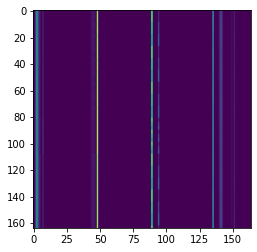

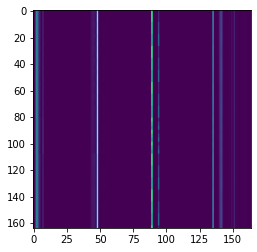

In [14]:
plt.imshow(c620_wt.head(41*4).values)
plt.show()
plt.imshow(c620_wt_gt.head(41*4).values)

In [15]:
predict.model_c620_sf.show_metrics(c620_wt,c620_wt_gt,e=2e-2)

,R2,MSE,MAPE
Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Hydrogen_wt%,1,0,NaN
Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Methane_wt%,0.999096,1.27325e-05,0.138945
Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Ethane_wt%,0.99913,0.00299312,0.0999336
Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Propane_wt%,0.997581,0.000833486,0.0575662
Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_n-Butane_wt%,0.99909,0.00101999,0.280407
...,...,...,...
Tatoray Stripper C620 Operation_Bottoms Production Rate and Composition_n-Pentylbenzene_wt%,0.999996,1.08858e-08,0.0199364
Tatoray Stripper C620 Operation_Bottoms Production Rate and Composition_n-Hexylbenzene_wt%,0.999996,2.00646e-09,0.019936
Tatoray Stripper C620 Operation_Bottoms Production Rate and Composition_Nitrogen_wt%,1,0,NaN
Tatoray Stripper C620 Operation_Bottoms Production Rate and Composition_Oxygen_wt%,1,0,NaN


#C620 OP

In [16]:
c620_op = predict.c620_op(c620_x)
c620_op.head()

,Density_Vent Gas Production Rate and Composition,Density_Distillate Production Rate and Composition,Density_Sidedraw Production Rate and Composition,Density_Bottoms Production Rate and Composition,Tatoray Stripper C620 Operation_Yield Summary_Reflux Rate_m3/hr,Tatoray Stripper C620 Operation_Heat Duty_Condenser Heat Duty_Mkcal/hr,Tatoray Stripper C620 Operation_Heat Duty_Reboiler Heat Duty_Mkcal/hr,Tatoray Stripper C620 Operation_Column Temp Profile_C620 Tray 14 (Control)_oC,Tatoray Stripper C620 Operation_Column Temp Profile_C620 Tray 34 (Control)_oC
001-001,0.449519,0.784688,0.881338,0.871859,117.390770,11.880459,13.471623,174.677490,193.081100
001-002,0.449519,0.784688,0.881338,0.871859,117.390808,11.880461,13.471625,174.677490,193.081085
001-003,0.449519,0.784688,0.881338,0.871859,117.390778,11.880460,13.471623,174.677490,193.081100
001-004,0.447557,0.790730,0.881372,0.871859,116.055931,11.881465,13.438894,174.686478,193.085724
001-005,0.447557,0.790730,0.881372,0.871859,116.055931,11.881466,13.438895,174.686478,193.085724


In [17]:
c620_op_gt = predict.c620_df.loc[c620_op.index,c620_op.columns]
c620_op_gt.head()

,Density_Vent Gas Production Rate and Composition,Density_Distillate Production Rate and Composition,Density_Sidedraw Production Rate and Composition,Density_Bottoms Production Rate and Composition,Tatoray Stripper C620 Operation_Yield Summary_Reflux Rate_m3/hr,Tatoray Stripper C620 Operation_Heat Duty_Condenser Heat Duty_Mkcal/hr,Tatoray Stripper C620 Operation_Heat Duty_Reboiler Heat Duty_Mkcal/hr,Tatoray Stripper C620 Operation_Column Temp Profile_C620 Tray 14 (Control)_oC,Tatoray Stripper C620 Operation_Column Temp Profile_C620 Tray 34 (Control)_oC
001-001,0.449632,0.784431,0.881339,0.871859,116.902473,11.831793,13.421467,174.679169,193.078064
001-002,0.449633,0.784431,0.881339,0.871859,116.913414,11.832891,13.420790,174.680298,193.079437
001-003,0.449633,0.784431,0.881339,0.871859,116.907753,11.832324,13.420931,174.679718,193.078735
001-004,0.447516,0.790220,0.881372,0.871859,115.686234,11.881908,13.417187,174.687775,193.097900
001-005,0.447516,0.790220,0.881372,0.871859,115.692726,11.882563,13.416693,174.688446,193.098572


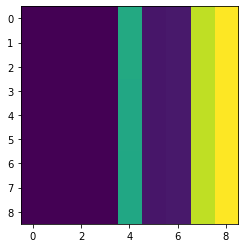

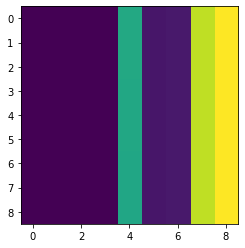

In [18]:
plt.imshow(c620_op.head(9).values)
plt.show()
plt.imshow(c620_op_gt.head(9).values)

In [19]:
predict.model_c620_op.show_metrics(c620_op,c620_op_gt,e=2e-2)

,R2,MSE,MAPE
Density_Vent Gas Production Rate and Composition,0.997477,5.8115e-08,0.0399281
Density_Distillate Production Rate and Composition,0.998542,1.57897e-07,0.0355595
Density_Sidedraw Production Rate and Composition,0.999815,2.11829e-10,0.00121763
Density_Bottoms Production Rate and Composition,0.999712,4.82042e-12,0.000180138
Tatoray Stripper C620 Operation_Yield Summary_Reflux Rate_m3/hr,0.998764,0.164621,0.260618
Tatoray Stripper C620 Operation_Heat Duty_Condenser Heat Duty_Mkcal/hr,0.999262,0.0009071,0.176614
Tatoray Stripper C620 Operation_Heat Duty_Reboiler Heat Duty_Mkcal/hr,0.999042,0.00162198,0.218545
Tatoray Stripper C620 Operation_Column Temp Profile_C620 Tray 14 (Control)_oC,0.999633,0.000487399,0.00920653
Tatoray Stripper C620 Operation_Column Temp Profile_C620 Tray 34 (Control)_oC,0.999643,0.000281092,0.0067282
AVG,0.999099,0.0186577,0.0831774


#C660 WT

In [20]:
#C660 Input
c660_x = predict.load_c660(c620_wt[predict.c620_col_names['sidedraw_x']])
c660_x.head()

,Benzene Column C660 Operation_Specifications_Spec 2 : NA in Benzene_ppmw,Benzene Column C660 Operation_Specifications_Spec 3 : Toluene in Benzene_ppmw,Combined Feed to Benzene Column C660_Detailed Composition_Hydrogen_wt%,Combined Feed to Benzene Column C660_Detailed Composition_Methane_wt%,Combined Feed to Benzene Column C660_Detailed Composition_Ethane_wt%,Combined Feed to Benzene Column C660_Detailed Composition_Propane_wt%,Combined Feed to Benzene Column C660_Detailed Composition_n-Butane_wt%,Combined Feed to Benzene Column C660_Detailed Composition_n-Pentane_wt%,Combined Feed to Benzene Column C660_Detailed Composition_n-Hexane_wt%,Combined Feed to Benzene Column C660_Detailed Composition_Benzene_wt%,Combined Feed to Benzene Column C660_Detailed Composition_Cyclohexane_wt%,Combined Feed to Benzene Column C660_Detailed Composition_n-Heptane_wt%,Combined Feed to Benzene Column C660_Detailed Composition_Water_wt%,Combined Feed to Benzene Column C660_Detailed Composition_Methylcyclohexane_wt%,Combined Feed to Benzene Column C660_Detailed Composition_Toluene_wt%,Combined Feed to Benzene Column C660_Detailed Composition_n-Octane_wt%,Combined Feed to Benzene Column C660_Detailed Composition_n-Propylcyclopentane_wt%,Combined Feed to Benzene Column C660_Detailed Composition_Ethylcyclohexane_wt%,Combined Feed to Benzene Column C660_Detailed Composition_Ethylbenzene_wt%,Combined Feed to Benzene Column C660_Detailed Composition_p-Xylene_wt%,Combined Feed to Benzene Column C660_Detailed Composition_m-Xylene_wt%,Combined Feed to Benzene Column C660_Detailed Composition_o-Xylene_wt%,Combined Feed to Benzene Column C660_Detailed Composition_n-Nonane_wt%,Combined Feed to Benzene Column C660_Detailed Composition_i-Propylbenzene_wt%,Combined Feed to Benzene Column C660_Detailed Composition_n-Propylcyclohexane_wt%,Combined Feed to Benzene Column C660_Detailed Composition_n-Propylbenzene_wt%,Combined Feed to Benzene Column C660_Detailed Composition_1-Methyl-3-ethylbenzene_wt%,Combined Feed to Benzene Column C660_Detailed Composition_1-Methyl-4-ethylbenzene_wt%,"Combined Feed to Benzene Column C660_Detailed Composition_1,3,5-Trimethylbenzene_wt%",Combined Feed to Benzene Column C660_Detailed Composition_1-Methyl-2-ethylbenzene_wt%,"Combined Feed to Benzene Column C660_Detailed Composition_1,2,4-Trimethylbenzene_wt%",Combined Feed to Benzene Column C660_Detailed Composition_tert-Butylcyclohexane_wt%,"Combined Feed to Benzene Column C660_Detailed Composition_1,2,3-Trimethylbenzene_wt%",Combined Feed to Benzene Column C660_Detailed Composition_Indane_wt%,Combined Feed to Benzene Column C660_Detailed Composition_1-Methyl-4-n-propylbenzene_wt%,"Combined Feed to Benzene Column C660_Detailed Composition_1,2-Diethylbenzene_wt%",Combined Feed to Benzene Column C660_Detailed Composition_5-Ethyl-m-xylene_wt%,"Combined Feed to Benzene Column C660_Detailed Composition_1,4-Diethylbenzene_wt%","Combined Feed to Benzene Column C660_Detailed Composition_1,2,3,5-Tetramethylbenzene_wt%",Combined Feed to Benzene Column C660_Detailed Composition_n-Pentylbenzene_wt%,Combined Feed to Benzene Column C660_Detailed Composition_n-Hexylbenzene_wt%,Combined Feed to Benzene Column C660_Detailed Composition_Nitrogen_wt%,Combined Feed to Benzene Column C660_Detailed Composition_Oxygen_wt%
001-001,979.958380,10.000000,0.0,0.000176,0.011406,0.021781,0.014997,0.019632,0.030144,66.272652,0.020974,0.034411,0.0,0.014614,27.878725,0.028611,0.024798,0.020281,3.132131,0.632325,1.318013,0.365564,0.044484,1.933783e-08,0.098763,3.360762e-09,0.001142,0.001141,0.002230,0.000570,0.000570,0.007880,3.863262e-09,1.669724e-10,0.001555,0.000415,5.971706e-10,0.0,6.420481e-12,3.065940e-13,2.993986e-16,0.0,0.0
001-002,979.858033,5.000000,0.0,0.000176,0.011406,0.021781,0.014997,0.019632,0.030144,66.272657,0.020974,0.034411,0.0,0.014614,27.878720,0.028611,0.024798,0.020281,3.132132,0.632325,1.318014,0.365564,0.044484,1.933776e-08,0.098764,3.360749e-09,0.001142,0.001141,0.002230,0.000570,0.000570,0.

In [21]:
c660_wt = predict.c660_wt(c660_x)
c660_wt.head()

,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Hydrogen_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Methane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Ethane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Propane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_n-Butane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_n-Pentane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_n-Hexane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Benzene_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Cyclohexane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_n-Heptane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Water_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Methylcyclohexane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Toluene_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_n-Octane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_n-Propylcyclopentane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Ethylcyclohexane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Ethylbenzene_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_p-Xylene_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_m-Xylene_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_o-Xylene_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_n-Nonane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_i-Propylbenzene_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_n-Propylcyclohexane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_n-Propylbenzene_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_1-Methyl-3-ethylbenzene_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_1-Methyl-4-ethylbenzene_wt%,"Benzene Column C660 Operation_Vent Gas Production Rate and Composition_1,3,5-Trimethylbenzene_wt%",Benzene Column C660 Operation_Vent Gas Production Rate and Composition_1-Methyl-2-ethylbenzene_wt%,"Benzene Column C660 Operation_Vent Gas Production Rate and Composition_1,2,4-Trimethylbenzene_wt%",Benzene Column C660 Operation_Vent Gas Production Rate and Composition_tert-Butylcyclohexane_wt%,"Benzene Column C660 Operation_Vent Gas Production Rate and Composition_1,2,3-Trimethylbenzene_wt%",Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Indane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_1-Methyl-4-n-propylbenzene_wt%,"Benzene Column C660 Operation_Vent Gas Production Rate and Composition_1,2-Diethylbenzene_wt%",Benzene Column C660 Operation_Vent Gas Production Rate and Composition_5-Ethyl-m-xylene_wt%,"Benzene Column C660 Operation_Vent Gas Production Rate and Composition_1,4-Diethylbenzene_wt%","Benzene Column C660 Operation_Vent Gas Production Rate and Composition_1,2,3,5-Tetramethylbenzene_wt%",Benzene Column C660 Operation_Vent Gas Production Rate and Composition_n-Pentylbenzene_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_n-Hexylbenzene_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Nitrogen_wt%,...,Benzene Column C660 Operation_Bottoms Production Rate and Composition_Methane_wt%,Benzene Column C660 Operation_Bottoms Production Rate and Composition_Ethane_wt%,Benzene Column C660 Operation_Bottoms Production Rate and Composition_Propane_wt%,Benzene Column C660 Operation_Bottoms Production Rate and Composition_n-Butane_wt%,Benzene Column C660 Operation_Bottoms Production Rate and Composit

In [22]:
c660_wt_gt = predict.c660_df.loc[c660_wt.index,c660_wt.columns]
c660_wt_gt.head()

,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Hydrogen_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Methane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Ethane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Propane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_n-Butane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_n-Pentane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_n-Hexane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Benzene_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Cyclohexane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_n-Heptane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Water_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Methylcyclohexane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Toluene_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_n-Octane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_n-Propylcyclopentane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Ethylcyclohexane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Ethylbenzene_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_p-Xylene_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_m-Xylene_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_o-Xylene_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_n-Nonane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_i-Propylbenzene_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_n-Propylcyclohexane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_n-Propylbenzene_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_1-Methyl-3-ethylbenzene_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_1-Methyl-4-ethylbenzene_wt%,"Benzene Column C660 Operation_Vent Gas Production Rate and Composition_1,3,5-Trimethylbenzene_wt%",Benzene Column C660 Operation_Vent Gas Production Rate and Composition_1-Methyl-2-ethylbenzene_wt%,"Benzene Column C660 Operation_Vent Gas Production Rate and Composition_1,2,4-Trimethylbenzene_wt%",Benzene Column C660 Operation_Vent Gas Production Rate and Composition_tert-Butylcyclohexane_wt%,"Benzene Column C660 Operation_Vent Gas Production Rate and Composition_1,2,3-Trimethylbenzene_wt%",Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Indane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_1-Methyl-4-n-propylbenzene_wt%,"Benzene Column C660 Operation_Vent Gas Production Rate and Composition_1,2-Diethylbenzene_wt%",Benzene Column C660 Operation_Vent Gas Production Rate and Composition_5-Ethyl-m-xylene_wt%,"Benzene Column C660 Operation_Vent Gas Production Rate and Composition_1,4-Diethylbenzene_wt%","Benzene Column C660 Operation_Vent Gas Production Rate and Composition_1,2,3,5-Tetramethylbenzene_wt%",Benzene Column C660 Operation_Vent Gas Production Rate and Composition_n-Pentylbenzene_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_n-Hexylbenzene_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Nitrogen_wt%,...,Benzene Column C660 Operation_Bottoms Production Rate and Composition_Methane_wt%,Benzene Column C660 Operation_Bottoms Production Rate and Composition_Ethane_wt%,Benzene Column C660 Operation_Bottoms Production Rate and Composition_Propane_wt%,Benzene Column C660 Operation_Bottoms Production Rate and Composition_n-Butane_wt%,Benzene Column C660 Operation_Bottoms Production Rate and Composit

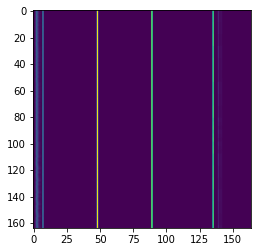

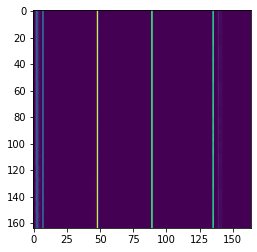

In [23]:
plt.imshow(c660_wt.head(41*4).values)
plt.show()
plt.imshow(c660_wt_gt.head(41*4).values)

In [24]:
predict.model_c660_sf.show_metrics(c660_wt,c660_wt_gt,e=2e-2)

,R2,MSE,MAPE
Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Hydrogen_wt%,1,0,NaN
Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Methane_wt%,0.964,0.00532466,2.80193
Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Ethane_wt%,0.993919,0.221159,1.31125
Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Propane_wt%,0.979706,0.101092,0.999208
Benzene Column C660 Operation_Vent Gas Production Rate and Composition_n-Butane_wt%,0.997751,0.027886,1.92118
...,...,...,...
Benzene Column C660 Operation_Bottoms Production Rate and Composition_n-Pentylbenzene_wt%,0.999909,1.36988e-27,NaN
Benzene Column C660 Operation_Bottoms Production Rate and Composition_n-Hexylbenzene_wt%,0.999905,1.75217e-33,NaN
Benzene Column C660 Operation_Bottoms Production Rate and Composition_Nitrogen_wt%,1,0,NaN
Benzene Column C660 Operation_Bottoms Production Rate and Composition_Oxygen_wt%,1,0,NaN


#C660 OP

In [25]:
c660_op = predict.c660_op(c660_x)
c660_op.head()

,Density_Vent Gas Production Rate and Composition,Density_Distillate (Benzene Drag) Production Rate and Composition,Density_Sidedraw (Benzene )Production Rate and Composition,Density_Bottoms Production Rate and Composition,Benzene Column C660 Operation_Yield Summary_Reflux Rate_m3/hr,Benzene Column C660 Operation_Heat Duty_Condenser Heat Duty_Mkcal/hr,Benzene Column C660 Operation_Heat Duty_Reboiler Heat Duty_Mkcal/hr,Benzene Column C660 Operation_Column Temp Profile_C660 Tray 6 (SD & Control)_oC,Benzene Column C660 Operation_Column Temp Profile_C660 Tray 23 (Control)_oC
001-001,0.527411,0.871393,0.883697,0.870044,91.726677,9.128889,8.550982,86.366554,88.621223
001-002,0.531663,0.870180,0.883697,0.870051,97.449936,9.632036,9.019180,86.396133,88.683655
001-003,0.534606,0.869351,0.883697,0.870052,103.795929,10.206443,9.587207,86.431190,88.759308
001-004,0.526215,0.871853,0.883705,0.870047,91.206673,9.101824,8.541093,86.365967,88.629433
001-005,0.529870,0.870801,0.883705,0.870044,96.889900,9.595931,9.022017,86.395775,88.686310


In [26]:
c660_op_gt = predict.c660_df.loc[c660_op.index,c660_op.columns]
c660_op_gt.head()

,Density_Vent Gas Production Rate and Composition,Density_Distillate (Benzene Drag) Production Rate and Composition,Density_Sidedraw (Benzene )Production Rate and Composition,Density_Bottoms Production Rate and Composition,Benzene Column C660 Operation_Yield Summary_Reflux Rate_m3/hr,Benzene Column C660 Operation_Heat Duty_Condenser Heat Duty_Mkcal/hr,Benzene Column C660 Operation_Heat Duty_Reboiler Heat Duty_Mkcal/hr,Benzene Column C660 Operation_Column Temp Profile_C660 Tray 6 (SD & Control)_oC,Benzene Column C660 Operation_Column Temp Profile_C660 Tray 23 (Control)_oC
001-001,0.527970,0.871164,0.883697,0.870042,92.053581,9.170740,8.579609,86.367523,88.610596
001-002,0.532121,0.869987,0.883697,0.870040,97.747383,9.671293,9.089737,86.398682,88.668610
001-003,0.535616,0.868997,0.883697,0.870039,104.241364,10.260563,9.686745,86.436920,88.776123
001-004,0.526486,0.871840,0.883705,0.870041,91.088814,9.095900,8.514075,86.364777,88.596405
001-005,0.530887,0.870613,0.883705,0.870039,96.766853,9.590916,9.018928,86.395142,88.651093


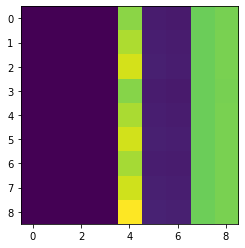

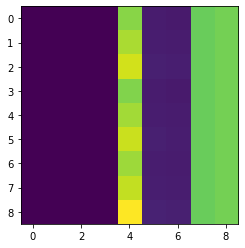

In [27]:
plt.imshow(c660_op.head(9).values)
plt.show()
plt.imshow(c660_op_gt.head(9).values)

In [28]:
predict.model_c660_op.show_metrics(c660_op,c660_op_gt,e=2e-2)

,R2,MSE,MAPE
Density_Vent Gas Production Rate and Composition,0.998135,5.8873e-07,0.110204
Density_Distillate (Benzene Drag) Production Rate and Composition,0.997901,1.60823e-07,0.0347555
Density_Sidedraw (Benzene )Production Rate and Composition,0.987597,1.27653e-12,0.000100243
Density_Bottoms Production Rate and Composition,0.999028,7.37155e-11,0.000727805
Benzene Column C660 Operation_Yield Summary_Reflux Rate_m3/hr,0.998291,1.44246,0.712573
Benzene Column C660 Operation_Heat Duty_Condenser Heat Duty_Mkcal/hr,0.998156,0.0119721,0.671844
Benzene Column C660 Operation_Heat Duty_Reboiler Heat Duty_Mkcal/hr,0.997959,0.0141816,0.706511
Benzene Column C660 Operation_Column Temp Profile_C660 Tray 6 (SD & Control)_oC,0.998172,8.0336e-05,0.00790942
Benzene Column C660 Operation_Column Temp Profile_C660 Tray 23 (Control)_oC,0.997657,0.00187968,0.0363039
AVG,0.996988,0.163397,0.253437


# C670 WT

In [29]:
#C670 Input
c620_w4,c660_w4 = c620_wt[predict.c620_col_names['bottoms_x']],c660_wt[predict.c660_col_names['bottoms_x']]
c670_x = predict.load_c670(c620_w4,c660_w4)
c670_x.head()

,Toluene Column C670 Operation_Combined Feed to Toluene Column C670 : Detailed weight % Composition_Hydrogen_wt%,Toluene Column C670 Operation_Combined Feed to Toluene Column C670 : Detailed weight % Composition_Methane_wt%,Toluene Column C670 Operation_Combined Feed to Toluene Column C670 : Detailed weight % Composition_Ethane_wt%,Toluene Column C670 Operation_Combined Feed to Toluene Column C670 : Detailed weight % Composition_Propane_wt%,Toluene Column C670 Operation_Combined Feed to Toluene Column C670 : Detailed weight % Composition_n-Butane_wt%,Toluene Column C670 Operation_Combined Feed to Toluene Column C670 : Detailed weight % Composition_n-Pentane_wt%,Toluene Column C670 Operation_Combined Feed to Toluene Column C670 : Detailed weight % Composition_n-Hexane_wt%,Toluene Column C670 Operation_Combined Feed to Toluene Column C670 : Detailed weight % Composition_Benzene_wt%,Toluene Column C670 Operation_Combined Feed to Toluene Column C670 : Detailed weight % Composition_Cyclohexane_wt%,Toluene Column C670 Operation_Combined Feed to Toluene Column C670 : Detailed weight % Composition_n-Heptane_wt%,Toluene Column C670 Operation_Combined Feed to Toluene Column C670 : Detailed weight % Composition_Water_wt%,Toluene Column C670 Operation_Combined Feed to Toluene Column C670 : Detailed weight % Composition_Methylcyclohexane_wt%,Toluene Column C670 Operation_Combined Feed to Toluene Column C670 : Detailed weight % Composition_Toluene_wt%,Toluene Column C670 Operation_Combined Feed to Toluene Column C670 : Detailed weight % Composition_n-Octane_wt%,Toluene Column C670 Operation_Combined Feed to Toluene Column C670 : Detailed weight % Composition_n-Propylcyclopentane_wt%,Toluene Column C670 Operation_Combined Feed to Toluene Column C670 : Detailed weight % Composition_Ethylcyclohexane_wt%,Toluene Column C670 Operation_Combined Feed to Toluene Column C670 : Detailed weight % Composition_Ethylbenzene_wt%,Toluene Column C670 Operation_Combined Feed to Toluene Column C670 : Detailed weight % Composition_p-Xylene_wt%,Toluene Column C670 Operation_Combined Feed to Toluene Column C670 : Detailed weight % Composition_m-Xylene_wt%,Toluene Column C670 Operation_Combined Feed to Toluene Column C670 : Detailed weight % Composition_o-Xylene_wt%,Toluene Column C670 Operation_Combined Feed to Toluene Column C670 : Detailed weight % Composition_n-Nonane_wt%,Toluene Column C670 Operation_Combined Feed to Toluene Column C670 : Detailed weight % Composition_i-Propylbenzene_wt%,Toluene Column C670 Operation_Combined Feed to Toluene Column C670 : Detailed weight % Composition_n-Propylcyclohexane_wt%,Toluene Column C670 Operation_Combined Feed to Toluene Column C670 : Detailed weight % Composition_n-Propylbenzene_wt%,Toluene Column C670 Operation_Combined Feed to Toluene Column C670 : Detailed weight % Composition_1-Methyl-3-ethylbenzene_wt%,Toluene Column C670 Operation_Combined Feed to Toluene Column C670 : Detailed weight % Composition_1-Methyl-4-ethylbenzene_wt%,"Toluene Column C670 Operation_Combined Feed to Toluene Column C670 : Detailed weight % Composition_1,3,5-Trimethylbenzene_wt%",Toluene Column C670 Operation_Combined Feed to Toluene Column C670 : Detailed weight % Composition_1-Methyl-2-ethylbenzene_wt%,"Toluene Column C670 Operation_Combined Feed to Toluene Column C670 : Detailed weight % Composition_1,2,4-Trimethylbenzene_wt%",Toluene Column C670 Operation_Combined Feed to Toluene Column C670 : Detailed weight % Composition_tert-Butylcyclohexane_wt%,"Toluene Column C670 Operation_Combined Feed to Toluene Column C670 : Detailed weight % Composition_1,2,3-Trimethylbenzene_wt%",Toluene Column C670 Operation_Combined Feed to Toluene Column C670 : Detailed weight % Composition_Indane_wt%,Toluene Column C670 Operation_Combined Feed to Toluene Column C670 : Detailed weight % Composition_1-Methyl-4-n-propylbenzene_wt%,"Toluene Column C670 Operation_Combined Feed to Toluene Column C670 : Detailed weight % Composition_1,2-Diethylbenzene_wt%",Tol

In [30]:
c670_wt = predict.c670_wt(c670_x)
c670_wt = c670_wt.dropna(axis=0)
c670_wt.head()

,Toluene Column C670 Operation_Distillate Production Rate and Composition_Hydrogen_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_Methane_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_Ethane_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_Propane_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_n-Butane_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_n-Pentane_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_n-Hexane_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_Benzene_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_Cyclohexane_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_n-Heptane_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_Water_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_Methylcyclohexane_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_Toluene_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_n-Octane_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_n-Propylcyclopentane_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_Ethylcyclohexane_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_Ethylbenzene_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_p-Xylene_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_m-Xylene_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_o-Xylene_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_n-Nonane_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_i-Propylbenzene_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_n-Propylcyclohexane_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_n-Propylbenzene_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_1-Methyl-3-ethylbenzene_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_1-Methyl-4-ethylbenzene_wt%,"Toluene Column C670 Operation_Distillate Production Rate and Composition_1,3,5-Trimethylbenzene_wt%",Toluene Column C670 Operation_Distillate Production Rate and Composition_1-Methyl-2-ethylbenzene_wt%,"Toluene Column C670 Operation_Distillate Production Rate and Composition_1,2,4-Trimethylbenzene_wt%",Toluene Column C670 Operation_Distillate Production Rate and Composition_tert-Butylcyclohexane_wt%,"Toluene Column C670 Operation_Distillate Production Rate and Composition_1,2,3-Trimethylbenzene_wt%",Toluene Column C670 Operation_Distillate Production Rate and Composition_Indane_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_1-Methyl-4-n-propylbenzene_wt%,"Toluene Column C670 Operation_Distillate Production Rate and Composition_1,2-Diethylbenzene_wt%",Toluene Column C670 Operation_Distillate Production Rate and Composition_5-Ethyl-m-xylene_wt%,"Toluene Column C670 Operation_Distillate Production Rate and Composition_1,4-Diethylbenzene_wt%","Toluene Column C670 Operation_Distillate Production Rate and Composition_1,2,3,5-Tetramethylbenzene_wt%",Toluene Column C670 Operation_Distillate Production Rate and Composition_n-Pentylbenzene_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_n-Hexylbenzene_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_Nitrogen_wt%,...,Toluene Column C670 Operation_Bottoms Production Rate and Composition_Methane_wt%,Toluene Column C670 Operation_Bottoms Production Rate and Composition_Ethane_wt%,Toluene Column C670 Operation_Bottoms Production Rate and Composition_Propane_wt%,Toluene Column C670 Operation_Bottoms Production Rate and Composition

In [31]:
c670_wt_gt = predict.c670_df.loc[c670_wt.index,c670_wt.columns]
c670_wt_gt.head()

,Toluene Column C670 Operation_Distillate Production Rate and Composition_Hydrogen_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_Methane_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_Ethane_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_Propane_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_n-Butane_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_n-Pentane_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_n-Hexane_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_Benzene_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_Cyclohexane_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_n-Heptane_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_Water_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_Methylcyclohexane_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_Toluene_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_n-Octane_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_n-Propylcyclopentane_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_Ethylcyclohexane_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_Ethylbenzene_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_p-Xylene_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_m-Xylene_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_o-Xylene_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_n-Nonane_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_i-Propylbenzene_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_n-Propylcyclohexane_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_n-Propylbenzene_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_1-Methyl-3-ethylbenzene_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_1-Methyl-4-ethylbenzene_wt%,"Toluene Column C670 Operation_Distillate Production Rate and Composition_1,3,5-Trimethylbenzene_wt%",Toluene Column C670 Operation_Distillate Production Rate and Composition_1-Methyl-2-ethylbenzene_wt%,"Toluene Column C670 Operation_Distillate Production Rate and Composition_1,2,4-Trimethylbenzene_wt%",Toluene Column C670 Operation_Distillate Production Rate and Composition_tert-Butylcyclohexane_wt%,"Toluene Column C670 Operation_Distillate Production Rate and Composition_1,2,3-Trimethylbenzene_wt%",Toluene Column C670 Operation_Distillate Production Rate and Composition_Indane_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_1-Methyl-4-n-propylbenzene_wt%,"Toluene Column C670 Operation_Distillate Production Rate and Composition_1,2-Diethylbenzene_wt%",Toluene Column C670 Operation_Distillate Production Rate and Composition_5-Ethyl-m-xylene_wt%,"Toluene Column C670 Operation_Distillate Production Rate and Composition_1,4-Diethylbenzene_wt%","Toluene Column C670 Operation_Distillate Production Rate and Composition_1,2,3,5-Tetramethylbenzene_wt%",Toluene Column C670 Operation_Distillate Production Rate and Composition_n-Pentylbenzene_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_n-Hexylbenzene_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_Nitrogen_wt%,...,Toluene Column C670 Operation_Bottoms Production Rate and Composition_Methane_wt%,Toluene Column C670 Operation_Bottoms Production Rate and Composition_Ethane_wt%,Toluene Column C670 Operation_Bottoms Production Rate and Composition_Propane_wt%,Toluene Column C670 Operation_Bottoms Production Rate and Composition

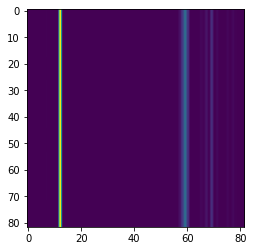

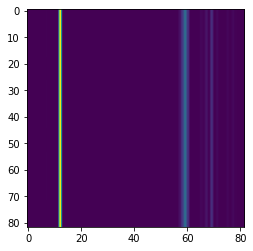

In [32]:
plt.imshow(c670_wt.head(41*2).values)
plt.show()
plt.imshow(c670_wt_gt.head(41*2).values)

In [33]:
predict.model_c670_sf.show_metrics(c670_wt,c670_wt_gt,e=2e-2)

,R2,MSE,MAPE
Toluene Column C670 Operation_Distillate Production Rate and Composition_Hydrogen_wt%,1,0,NaN
Toluene Column C670 Operation_Distillate Production Rate and Composition_Methane_wt%,0,9.19171e-12,NaN
Toluene Column C670 Operation_Distillate Production Rate and Composition_Ethane_wt%,0,6.32504e-09,NaN
Toluene Column C670 Operation_Distillate Production Rate and Composition_Propane_wt%,0,4.55847e-09,NaN
Toluene Column C670 Operation_Distillate Production Rate and Composition_n-Butane_wt%,0,6.2131e-47,NaN
...,...,...,...
Toluene Column C670 Operation_Bottoms Production Rate and Composition_n-Pentylbenzene_wt%,1,1.1773e-08,0.0132137
Toluene Column C670 Operation_Bottoms Production Rate and Composition_n-Hexylbenzene_wt%,1,2.16842e-09,0.0132134
Toluene Column C670 Operation_Bottoms Production Rate and Composition_Nitrogen_wt%,1,0,NaN
Toluene Column C670 Operation_Bottoms Production Rate and Composition_Oxygen_wt%,1,0,NaN


#C670 OP

In [34]:
c670_op = predict.c670_op(c670_x)
c670_op.head()

,Density_Distillate Production Rate and Composition,Density_Bottoms Production Rate and Composition,Toluene Column C670 Operation_Yield \nSummary_Reflux Rate_m3/hr,Toluene Column C670 Operation_Heat Duty_Condenser Heat Duty_Mkcal/hr,Toluene Column C670 Operation_Heat Duty_Reboiler Heat Duty_Mkcal/hr,Toluene Column C670 Operation_Column Temp Profile_C670 Tray 24 (Control)_oC,Toluene Column C670 Operation_Column Temp Profile_C670 Btm Temp (Control)_oC
001-001,0.870806,0.871991,200.611542,23.626154,23.838886,180.939270,224.359665
001-002,0.870806,0.871991,200.611542,23.626154,23.838886,180.939270,224.359665
001-003,0.870806,0.871991,200.611542,23.626154,23.838886,180.939285,224.359665
001-004,0.870806,0.871991,200.611542,23.626154,23.838886,180.939270,224.359665
001-005,0.870806,0.871991,200.611542,23.626154,23.838886,180.939270,224.359665


In [35]:
c670_op_gt = predict.c670_df.loc[c670_op.index,c670_op.columns]
c670_op_gt.head()

,Density_Distillate Production Rate and Composition,Density_Bottoms Production Rate and Composition,Toluene Column C670 Operation_Yield \nSummary_Reflux Rate_m3/hr,Toluene Column C670 Operation_Heat Duty_Condenser Heat Duty_Mkcal/hr,Toluene Column C670 Operation_Heat Duty_Reboiler Heat Duty_Mkcal/hr,Toluene Column C670 Operation_Column Temp Profile_C670 Tray 24 (Control)_oC,Toluene Column C670 Operation_Column Temp Profile_C670 Btm Temp (Control)_oC
001-001,0.870898,0.872382,237.497345,25.174679,25.868053,181.798798,224.620972
001-002,0.870897,0.872382,237.501434,25.175015,25.867839,181.798828,224.621002
001-003,0.870897,0.872382,237.496521,25.174639,25.868182,181.798706,224.620972
001-004,0.870898,0.872382,237.723160,25.192291,25.860675,181.803101,224.622864
001-005,0.870897,0.872382,237.728455,25.192725,25.860317,181.803192,224.622925


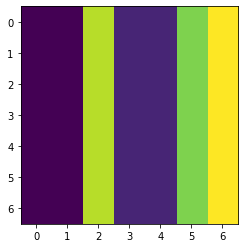

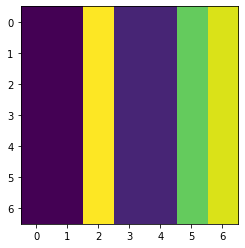

In [36]:
plt.imshow(c670_op.head(7).values)
plt.show()
plt.imshow(c670_op_gt.head(7).values)

In [37]:
predict.model_c670_op.show_metrics(c670_op,c670_op_gt,e=2e-2)

,R2,MSE,MAPE
Density_Distillate Production Rate and Composition,0,8.19923e-09,0.0101846
Density_Bottoms Production Rate and Composition,0,3.15841e-07,0.0587012
Toluene Column C670 Operation_Yield \nSummary_Reflux Rate_m3/hr,0,4182.01,29.7683
Toluene Column C670 Operation_Heat Duty_Condenser Heat Duty_Mkcal/hr,0,47.8122,26.449
Toluene Column C670 Operation_Heat Duty_Reboiler Heat Duty_Mkcal/hr,0,48.3191,26.5214
Toluene Column C670 Operation_Column Temp Profile_C670 Tray 24 (Control)_oC,0,0.310584,0.277022
Toluene Column C670 Operation_Column Temp Profile_C670 Btm Temp (Control)_oC,0,9.18674,1.133
AVG,0,612.52,12.0311
